# Using PCA Analysis for Face Recognition
- By Sagar Sarkale
- We will use principal component analysis (PCA) to reduce the dimensionality
- And we will kNN classifier to identify the faces

# Importing Libraries

In [1]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

# for evaluation of the model
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt 

import numpy as np

%matplotlib inline

# Load Datasets
We will use the [Olivetti Faces](http://scikit-learn.org/stable/datasets/olivetti_faces.html) dataset. It has 10 faces each of 40 persons as 64x64 images.

In [2]:
faces_data = datasets.fetch_olivetti_faces()

# Summary of the data

In [3]:
n_samples, height, width = faces_data.images.shape
x = faces_data.data
y = faces_data.target

# we have 10 images of each person making it total 400 images
# we have total 40 classes 0-39 one for each person
print("Shape of feature matrix",x.shape)
print("Number of classes values",max(y)+1)
print("Height of each image",height)
print("Width of each image",width)

Shape of feature matrix (400, 4096)
Number of classes values 40
Height of each image 64
Width of each image 64


# train_test_split( )
Here we split the data into:
1. test data   (25%)
2. train data (75%)

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x,y, 
                                                    test_size=0.25, random_state=30 )

# Mean image
- We calculate mean image for optimisation
- It is also used in calculating covariance matrix
- Consider image matrix I and mean image matrix M
- therefore the mean normalised matrix is given by
### ```Mean normalised Matrix = I-M```

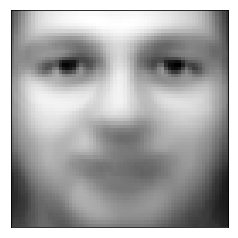

In [5]:
# finding mean image of complete image dataset
mean_image = np.mean(x_train, axis=0)

# visualizing mean image 
plt.figure()
plt.imshow(mean_image.reshape(64,64),cmap=plt.cm.gray)

# By using xtick,ytick you can position tick marks along the axes
plt.xticks(())
plt.yticks(())
plt.show()

# Utility function to view images

In [6]:
"""
Helper function to plot a gallery of portraits
Taken from:
http://scikit-learn.org/stable/auto_examples/applications/face_recognition.html
"""
def plot_gallery(images, h, w, titles=None, n_row=3, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        if titles != None:
            plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

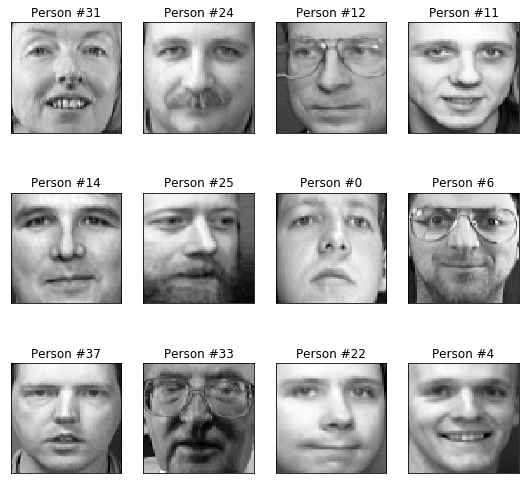

In [7]:
chosen_images = x_train[:12]
chosen_labels = y_train[:12]
titles = ['Person #'+str(i) for i in chosen_labels]

plot_gallery(chosen_images, height, width, titles)

# Calculate Eigen Faces
We call each `Principal Component as Eigen Face`<br>
in face recognition application

Also ```Each Eigen Vector is called a Principal Component```<br>

> 1. Calculate mean_normalized_image matrix (X) of shape (4096, N)
> 2. Calculate covariance matrix of X
>> - cov_matrix(R)  =   X * X<sup>T</sup>
> 3. Using Diagonalisation for calculating Eigen Vectors
>> - this procedure represents the matrix R as follows
>> - R  =  P \*  D  \* P<sup>T</sup>
>> - Where P is matrix of Eigen vectors column wise
>> - P<sup>T</sup> is transpose of P
>> - D is `Diagonal matrix` consisting `Eigen Values`<br>Such that each element of P has <br>
corresponding Eigen value in the Diagonal matrix

<hr>
Some useful References:
- [PCA sklearn Documentation](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)
- [Purpose of Whitening](https://www.quora.com/What-is-the-purpose-of-data-whitening-in-machine-learning)
- [Interpretation of the Whitening Transform](https://www.quora.com/What-is-the-use-of-Whitening-images-as-a-preprocessing-step-for-a-Convolutional-Neural-Network)

### NOTE
<br>
- While the eigendecomposition of the covariance or correlation matrix may be more intuitiuve,<br> 
- most PCA implementations perform a `Singular Vector Decomposition (SVD)` to improve the computational efficiency.
<HR>


1. In order to decide `which eigenvector(s) can dropped without losing too much information`<br>
    for the construction of lower-dimensional subspace
2. we need to inspect the corresponding eigenvalues: 
3. The `eigenvectors with the lowest eigenvalues bear the least information` <br>
    about the distribution of the data; those are the ones can be dropped.
4. In order to do so, the common approach is to `rank the eigenvalues`<br>
   from `highest to lowest` in order choose the `top k eigenvectors`.

These steps are done by <br>
`pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True)`<br>
The dimensionality reduction is done when pca.transform(X) is done

[Reference](https://plot.ly/ipython-notebooks/principal-component-analysis/#singular-vector-decomposition)
<hr>

In [8]:
# we choose dimensionality of the feacture space
n_components = 120

# using randomized PCA 
# this is just a decompostion tool
# Linear dimensionality reduction using approximated Singular Value Decomposition 
# of the data and keeping only the most significant singular vectors to project 
# the data to a lower dimensional space.

pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True)
pca.fit(x_train)

PCA(copy=True, iterated_power='auto', n_components=120, random_state=None,
  svd_solver='randomized', tol=0.0, whiten=True)

In [9]:
# finding eigen vectors of the feature space
eigenfaces = pca.components_.reshape((n_components, height, width))
print("shape of P^T matrix: ",pca.components_.shape)
print("shape of eigenfaces matrix: ",eigenfaces.shape)

# pca.components_ is the orthogonal basis of the space your projecting the data into. 
# It has shape (n_components, n_features)
# pca.components_ is the set of all eigenvectors 
# (aka loadings) for your projection space

shape of P^T matrix:  (120, 4096)
shape of eigenfaces matrix:  (120, 64, 64)


## Visualising eigen faces

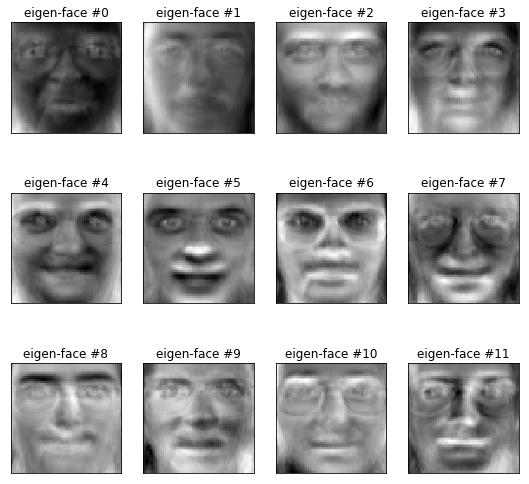

In [10]:
titles = ['eigen-face #'+str(i) for i in range(12)]
plot_gallery(eigenfaces, height, width, titles)

## Transform the data to the vector space spanned by the eigen faces

In [11]:
# Projecting the data onto the eigenspace
# Applying dimensionality reduction to X

x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

# here we choose top n_components
# i.e eigen values and corresponding eigen vectors
# these components are chosen 
# on the basis of magnitude
# larger the magnitude more is the 
# contribution of that eigen vector in feature space

# it is very important to check the shape of x_train_pca 
# as it should be same as y_train so that it fits in
# our classifier model
print("Current shape of i/p data matrix : ",x_train_pca.shape)

Current shape of i/p data matrix :  (300, 120)


# Using kNN Classifier
Now we use kNN Classifier to classify these faces

In [12]:
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(x_train_pca,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [13]:
import warnings
warnings.filterwarnings('ignore')

# detecting faces in test set
y_test_pred = knn_model.predict(x_test_pca)
correct_count = 0.0

for i in range(0,len(x_test)):
    if y_test[i] == y_test_pred[i]:
        correct_count += 1.0

# calculating accuracy
accuracy = correct_count/float(len(y_test))
print("Accuracy : ",accuracy,"\n")
print(classification_report(y_test, y_test_pred))


Accuracy :  0.64 

             precision    recall  f1-score   support

          0       0.50      0.50      0.50         2
          1       1.00      0.50      0.67         4
          2       1.00      0.67      0.80         3
          3       0.50      0.67      0.57         3
          4       0.00      0.00      0.00         0
          5       0.67      1.00      0.80         2
          6       0.00      0.00      0.00         2
          7       1.00      0.50      0.67         4
          8       0.33      1.00      0.50         1
          9       1.00      0.75      0.86         4
         10       1.00      1.00      1.00         2
         11       1.00      0.75      0.86         4
         12       0.00      0.00      0.00         3
         13       1.00      1.00      1.00         1
         14       0.25      1.00      0.40         4
         15       0.00      0.00      0.00         2
         16       1.00      0.33      0.50         3
         17       0.50    

In [14]:
# creating a confusion matrix
print(confusion_matrix(y_test, y_test_pred))

[[1 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]


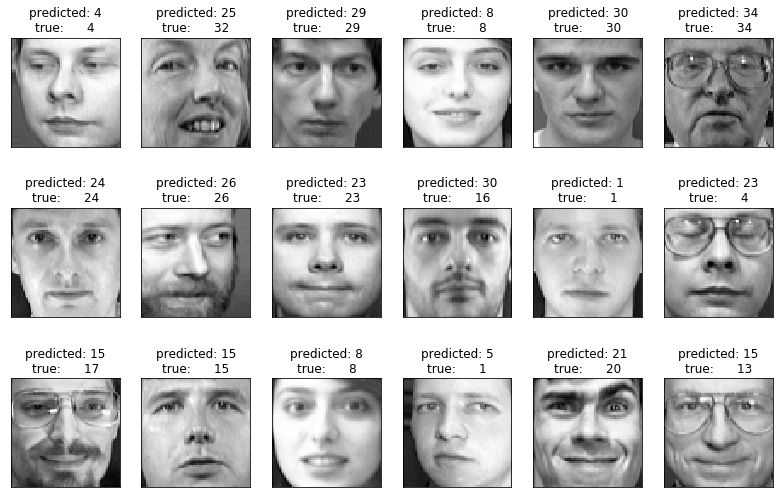

In [15]:
# utility function for marking titles
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)


target_names = [str(element) for element in np.arange(40)+1]

# list of titles
prediction_titles = [title(y_test_pred, y_test, target_names, i)
                     for i in range(y_test_pred.shape[0])]

# calling plot gallery for viewing predictions
plot_gallery(x_test, height, width, prediction_titles, n_row=3, n_col=6)

plt.show()